-- Eval the parquet files dropped into s3

In [2]:
# Cell 1: Setup and Imports (Fixed for s3fs compatibility)
import boto3
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
from dotenv import load_dotenv
import os
load_dotenv()

# S3 Configuration
S3_BUCKET = os.getenv('S3_BUCKET', 'commercial-rates')
S3_PREFIX = 'tic-mrf/test'
AWS_REGION = os.getenv('AWS_DEFAULT_REGION', 'us-east-2')

print(f"🔧 S3 Configuration:")
print(f"   Bucket: {S3_BUCKET}")
print(f"   Prefix: {S3_PREFIX}")
print(f"   Region: {AWS_REGION}")

# Initialize S3 client (more reliable approach)
s3_client = boto3.client(
    's3',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
    region_name=AWS_REGION
)

# Try to initialize s3fs with different approaches
fs = None
try:
    import s3fs
    # Try new s3fs version syntax
    fs = s3fs.S3FileSystem(
        key=os.getenv('AWS_ACCESS_KEY_ID'),
        secret=os.getenv('AWS_SECRET_ACCESS_KEY'),
        region_name=AWS_REGION
    )
    print("✅ S3 filesystem initialized (new s3fs version)")
except Exception as e1:
    try:
        # Try older s3fs version syntax
        fs = s3fs.S3FileSystem(
            key=os.getenv('AWS_ACCESS_KEY_ID'),
            secret=os.getenv('AWS_SECRET_ACCESS_KEY'),
            region=AWS_REGION
        )
        print("✅ S3 filesystem initialized (older s3fs version)")
    except Exception as e2:
        try:
            # Try without explicit credentials (use environment)
            fs = s3fs.S3FileSystem()
            print("✅ S3 filesystem initialized (using environment credentials)")
        except Exception as e3:
            print(f"❌ Could not initialize s3fs: {e3}")
            print("   Will use boto3 client for S3 operations")

# Alternative function using boto3 directly
def list_s3_objects_boto3(bucket, prefix):
    """List S3 objects using boto3 client."""
    try:
        paginator = s3_client.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=bucket, Prefix=prefix)
        
        objects = []
        for page in pages:
            if 'Contents' in page:
                for obj in page['Contents']:
                    if obj['Key'].endswith('.parquet'):
                        objects.append({
                            'key': obj['Key'],
                            'size': obj['Size'],
                            'last_modified': obj['LastModified']
                        })
        return objects
    except Exception as e:
        print(f"Error listing S3 objects: {e}")
        return []

print("✅ S3 client initialized with boto3 fallback")

🔧 S3 Configuration:
   Bucket: commercial-rates
   Prefix: tic-mrf/test
   Region: us-east-2
✅ S3 filesystem initialized (new s3fs version)
✅ S3 client initialized with boto3 fallback


-- File Discovery

In [3]:
# Cell 2: Discover S3 Files
def discover_s3_files():
    """Discover all parquet files in the S3 bucket using boto3."""
    base_path = f"{S3_BUCKET}/{S3_PREFIX}"
    
    print(f"🔍 Discovering files in s3://{base_path}/")
    
    try:
        # Use boto3 to list objects
        paginator = s3_client.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=S3_BUCKET, Prefix=S3_PREFIX)
        
        all_files = []
        for page in pages:
            if 'Contents' in page:
                for obj in page['Contents']:
                    if obj['Key'].endswith('.parquet'):
                        file_path = f"s3://{S3_BUCKET}/{obj['Key']}"
                        all_files.append({
                            'path': file_path,
                            'key': obj['Key'],
                            'size': obj['Size'],
                            'last_modified': obj['LastModified']
                        })
        
        print(f"   Found {len(all_files)} parquet files")
        
        if not all_files:
            print("❌ No parquet files found")
            return {}
        
        # Organize by data type
        file_structure = {
            'rates': [],
            'organizations': [],
            'providers': [],
            'payers': [],
            'analytics': [],
            'other': []
        }
        
        for file_info in all_files:
            file_path = file_info['path']
            file_key = file_info['key']
            
            # Categorize files based on the actual file path structure
            if '/rates/' in file_path or '_rates_' in file_key:
                file_structure['rates'].append(file_info)
            elif '/organizations/' in file_path or '_orgs_' in file_key:
                file_structure['organizations'].append(file_info)
            elif '/providers/' in file_path or '_providers_' in file_key:
                file_structure['providers'].append(file_info)
            elif '/payers/' in file_path or '_payers_' in file_key:
                file_structure['payers'].append(file_info)
            elif '/analytics/' in file_path or '_analytics_' in file_key:
                file_structure['analytics'].append(file_info)
            else:
                file_structure['other'].append(file_info)
        
        # Display summary
        print(f"\n📊 File Summary:")
        total_files = 0
        for data_type, files in file_structure.items():
            count = len(files)
            total_files += count
            if count > 0:
                print(f"   {data_type.capitalize()}: {count} files")
                
                # Show file sizes for first few files
                for file_info in files[:3]:
                    file_name = file_info['path'].split('/')[-1]
                    size_mb = file_info['size'] / 1024 / 1024
                    last_modified = file_info['last_modified'].strftime('%Y-%m-%d %H:%M')
                    print(f"     - {file_name}: {size_mb:.1f} MB (modified: {last_modified})")
                
                if count > 3:
                    print(f"     ... and {count - 3} more files")
        
        print(f"\n📈 Total: {total_files} parquet files")
        return file_structure
        
    except Exception as e:
        print(f"❌ Error discovering files: {e}")
        return {}

# Run discovery
file_structure = discover_s3_files()

🔍 Discovering files in s3://commercial-rates/tic-mrf/test/
   Found 15 parquet files

📊 File Summary:
   Rates: 5 files
     - centene_fidelis_plan_0_20250529_024332_rates_batch_0000_025331.parquet: 0.2 MB (modified: 2025-05-29 02:53)
     - centene_fidelis_plan_0_20250529_024332_rates_batch_0003_025335.parquet: 0.2 MB (modified: 2025-05-29 02:53)
     - centene_fidelis_plan_0_20250529_024332_rates_batch_0006_025339.parquet: 0.1 MB (modified: 2025-05-29 02:53)
     ... and 2 more files
   Organizations: 5 files
     - centene_fidelis_plan_0_20250529_024332_orgs_batch_0000_025331.parquet: 0.1 MB (modified: 2025-05-29 02:53)
     - centene_fidelis_plan_0_20250529_024332_orgs_batch_0003_025335.parquet: 0.0 MB (modified: 2025-05-29 02:53)
     - centene_fidelis_plan_0_20250529_024332_orgs_batch_0006_025339.parquet: 0.0 MB (modified: 2025-05-29 02:53)
     ... and 2 more files
   Providers: 5 files
     - centene_fidelis_plan_0_20250529_024332_providers_batch_0000_025331.parquet: 0.5 MB (mo

-- asssess the column names

In [11]:
# Cell 2: Discover S3 Files
def discover_s3_files():
    """Discover all parquet files in the S3 bucket using boto3."""
    base_path = f"{S3_BUCKET}/{S3_PREFIX}"
    
    print(f"🔍 Discovering files in s3://{base_path}/")
    
    try:
        # Use boto3 to list objects
        paginator = s3_client.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=S3_BUCKET, Prefix=S3_PREFIX)
        
        all_files = []
        for page in pages:
            if 'Contents' in page:
                for obj in page['Contents']:
                    if obj['Key'].endswith('.parquet'):
                        file_path = f"s3://{S3_BUCKET}/{obj['Key']}"
                        all_files.append({
                            'path': file_path,
                            'key': obj['Key'],
                            'size': obj['Size'],
                            'last_modified': obj['LastModified']
                        })
        
        print(f"   Found {len(all_files)} parquet files")
        
        if not all_files:
            print("❌ No parquet files found")
            return {}
        
        # Organize by data type
        file_structure = {
            'rates': [],
            'organizations': [],
            'providers': [],
            'payers': [],
            'analytics': [],
            'other': []
        }
        
        for file_info in all_files:
            file_path = file_info['path']
            
            # Categorize files
            if 'rates' in file_path:
                file_structure['rates'].append(file_info)
            elif 'organizations' in file_path:
                file_structure['organizations'].append(file_info)
            elif 'providers' in file_path:
                file_structure['providers'].append(file_info)
            elif 'payers' in file_path:
                file_structure['payers'].append(file_info)
            elif 'analytics' in file_path:
                file_structure['analytics'].append(file_info)
            else:
                file_structure['other'].append(file_info)
        
        # Display summary
        print(f"\n📊 File Summary:")
        total_files = 0
        for data_type, files in file_structure.items():
            count = len(files)
            total_files += count
            if count > 0:
                print(f"   {data_type.capitalize()}: {count} files")
                
                # Show file sizes for first few files
                for file_info in files[:3]:
                    file_name = file_info['path'].split('/')[-1]
                    size_mb = file_info['size'] / 1024 / 1024
                    last_modified = file_info['last_modified'].strftime('%Y-%m-%d %H:%M')
                    print(f"     - {file_name}: {size_mb:.1f} MB (modified: {last_modified})")
                
                if count > 3:
                    print(f"     ... and {count - 3} more files")
        
        print(f"\n📈 Total: {total_files} parquet files")
        return file_structure
        
    except Exception as e:
        print(f"❌ Error discovering files: {e}")
        return {}

# Run discovery
file_structure = discover_s3_files()

🔍 Discovering files in s3://commercial-rates/tic-mrf/test/
   Found 15 parquet files

📊 File Summary:
   Rates: 15 files
     - centene_fidelis_plan_0_20250529_024332_orgs_batch_0000_025331.parquet: 0.1 MB (modified: 2025-05-29 02:53)
     - centene_fidelis_plan_0_20250529_024332_orgs_batch_0003_025335.parquet: 0.0 MB (modified: 2025-05-29 02:53)
     - centene_fidelis_plan_0_20250529_024332_orgs_batch_0006_025339.parquet: 0.0 MB (modified: 2025-05-29 02:53)
     ... and 12 more files

📈 Total: 15 parquet files


-- rate analysis

In [12]:
# Cell 2: Discover S3 Files (Corrected for your file structure)
def discover_s3_files():
    """Discover all parquet files in the S3 bucket using boto3."""
    base_path = f"{S3_BUCKET}/{S3_PREFIX}"
    
    print(f"🔍 Discovering files in s3://{base_path}/")
    
    try:
        # Use boto3 to list objects
        paginator = s3_client.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=S3_BUCKET, Prefix=S3_PREFIX)
        
        all_files = []
        for page in pages:
            if 'Contents' in page:
                for obj in page['Contents']:
                    if obj['Key'].endswith('.parquet'):
                        file_path = f"s3://{S3_BUCKET}/{obj['Key']}"
                        all_files.append({
                            'path': file_path,
                            'key': obj['Key'],
                            'size': obj['Size'],
                            'last_modified': obj['LastModified']
                        })
        
        print(f"   Found {len(all_files)} parquet files")
        
        if not all_files:
            print("❌ No parquet files found")
            return {}
        
        # Organize by data type based on your actual file naming pattern
        file_structure = {
            'rates': [],
            'organizations': [],
            'providers': [],
            'payers': [],
            'analytics': [],
            'other': []
        }
        
        for file_info in all_files:
            file_path = file_info['path']
            file_key = file_info['key']
            file_name = file_key.split('/')[-1]
            
            # Categorize files based on your actual naming pattern
            if '_rates_batch_' in file_name:
                file_structure['rates'].append(file_info)
            elif '_orgs_batch_' in file_name:
                file_structure['organizations'].append(file_info)
            elif '_providers_batch_' in file_name:
                file_structure['providers'].append(file_info)
            elif '_payers_' in file_name:
                file_structure['payers'].append(file_info)
            elif '_analytics_' in file_name:
                file_structure['analytics'].append(file_info)
            else:
                file_structure['other'].append(file_info)
        
        # Display summary
        print(f"\n📊 File Summary:")
        total_files = 0
        for data_type, files in file_structure.items():
            count = len(files)
            total_files += count
            if count > 0:
                print(f"   {data_type.capitalize()}: {count} files")
                
                # Show file sizes for first few files
                for file_info in files[:3]:
                    file_name = file_info['path'].split('/')[-1]
                    size_mb = file_info['size'] / 1024 / 1024
                    last_modified = file_info['last_modified'].strftime('%Y-%m-%d %H:%M')
                    print(f"     - {file_name}: {size_mb:.1f} MB (modified: {last_modified})")
                
                if count > 3:
                    print(f"     ... and {count - 3} more files")
        
        print(f"\n📈 Total: {total_files} parquet files")
        return file_structure
        
    except Exception as e:
        print(f"❌ Error discovering files: {e}")
        return {}

# Run discovery
file_structure = discover_s3_files()

🔍 Discovering files in s3://commercial-rates/tic-mrf/test/
   Found 15 parquet files

📊 File Summary:
   Rates: 5 files
     - centene_fidelis_plan_0_20250529_024332_rates_batch_0000_025331.parquet: 0.2 MB (modified: 2025-05-29 02:53)
     - centene_fidelis_plan_0_20250529_024332_rates_batch_0003_025335.parquet: 0.2 MB (modified: 2025-05-29 02:53)
     - centene_fidelis_plan_0_20250529_024332_rates_batch_0006_025339.parquet: 0.1 MB (modified: 2025-05-29 02:53)
     ... and 2 more files
   Organizations: 5 files
     - centene_fidelis_plan_0_20250529_024332_orgs_batch_0000_025331.parquet: 0.1 MB (modified: 2025-05-29 02:53)
     - centene_fidelis_plan_0_20250529_024332_orgs_batch_0003_025335.parquet: 0.0 MB (modified: 2025-05-29 02:53)
     - centene_fidelis_plan_0_20250529_024332_orgs_batch_0006_025339.parquet: 0.0 MB (modified: 2025-05-29 02:53)
     ... and 2 more files
   Providers: 5 files
     - centene_fidelis_plan_0_20250529_024332_providers_batch_0000_025331.parquet: 0.5 MB (mo

--load rates parquet

In [13]:
# Cell 3: Load and Inspect Rates Data
def load_rates_sample(max_files=5, max_rows_per_file=10000):
    """Load a sample of rates data from S3."""
    
    if not file_structure.get('rates'):
        print("❌ No rates files found")
        return None
    
    print(f"📥 Loading rates data (max {max_files} files, {max_rows_per_file} rows each)...")
    
    dfs = []
    files_processed = 0
    
    for file_info in file_structure['rates'][:max_files]:
        try:
            file_path = file_info['path']
            file_name = file_path.split('/')[-1]
            print(f"   Loading: {file_name}")
            
            # Load file directly from S3 using pandas
            df = pd.read_parquet(file_path)
            
            # Limit rows if file is large
            if len(df) > max_rows_per_file:
                df = df.sample(n=max_rows_per_file, random_state=42)
                print(f"     Sampled {max_rows_per_file} rows from {len(df)} total")
            
            dfs.append(df)
            files_processed += 1
            
        except Exception as e:
            print(f"     ❌ Error loading {file_name}: {e}")
    
    if not dfs:
        print("❌ No files could be loaded")
        return None
    
    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    
    print(f"\n✅ Loaded {len(combined_df):,} rates records from {files_processed} files")
    
    return combined_df

# Load rates data
rates_df = load_rates_sample()

if rates_df is not None:
    print(f"\n📊 Rates Data Overview:")
    print(f"   Shape: {rates_df.shape}")
    print(f"   Memory usage: {rates_df.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")
    
    print(f"\n📋 Columns:")
    for i, col in enumerate(rates_df.columns):
        dtype = str(rates_df[col].dtype)
        null_count = rates_df[col].isnull().sum()
        null_pct = (null_count / len(rates_df)) * 100
        print(f"   {i+1:2d}. {col:25} | {dtype:15} | {null_count:6,} nulls ({null_pct:4.1f}%)")
    
    print(f"\n📈 Sample Data:")
    display(rates_df.head())

📥 Loading rates data (max 5 files, 10000 rows each)...
   Loading: centene_fidelis_plan_0_20250529_024332_rates_batch_0000_025331.parquet
   Loading: centene_fidelis_plan_0_20250529_024332_rates_batch_0003_025335.parquet
   Loading: centene_fidelis_plan_0_20250529_024332_rates_batch_0006_025339.parquet
   Loading: centene_fidelis_plan_1_20250529_025340_rates_batch_0000_025419.parquet
   Loading: centene_fidelis_plan_1_20250529_025340_rates_batch_0003_025430.parquet

✅ Loaded 4,634 rates records from 5 files

📊 Rates Data Overview:
   Shape: (4634, 20)
   Memory usage: 8.5 MB

📋 Columns:
    1. rate_uuid                 | object          |      0 nulls ( 0.0%)
    2. payer_uuid                | object          |      0 nulls ( 0.0%)
    3. organization_uuid         | object          |      0 nulls ( 0.0%)
    4. service_code              | object          |      0 nulls ( 0.0%)
    5. service_description       | object          |      0 nulls ( 0.0%)
    6. billing_code_type         | o

,rate_uuid,payer_uuid,organization_uuid,service_code,service_description,billing_code_type,negotiated_rate,billing_class,rate_type,service_codes,plan_details,contract_period,provider_network,geographic_scope,data_lineage,created_at,updated_at,quality_flags,payer,date
0,07e8e88a-6024-51cc-b909-9a4b0f599391,db18448f-0a71-51f8-9a6d-351171089123,b80c7d56-1b11-57a6-8d05-769f3e7727d5,0240U,NFCT DS RNA 3 TARGETS UPPER RESPIRATORY SPECIMEN,HCPCS,121.23,professional,negotiated,[11],"{'market_type': 'Commercial', 'plan_id': None,...","{'effective_date': None, 'expiration_date': '9...","{'coverage_type': 'Organization', 'npi_count':...","{'counties': [], 'states': [], 'zip_codes': []}",{'extraction_timestamp': 2025-05-29 02:43:35.6...,2025-05-29 02:43:35.672980+00:00,2025-05-29 02:43:35.672981+00:00,"{'confidence_score': 1.0, 'has_conflicts': Fal...",centene_fidelis,2025-05-29
1,4cdf340e-ef04-5867-9c2a-fbfaea19708a,db18448f-0a71-51f8-9a6d-351171089123,b80c7d56-1b11-57a6-8d05-769f3e7727d5,0241U,NFCT DS RNA 4 TARGETS UPPER RESPIRATORY SPECIMEN,HCPCS,249.62,professional,negotiated,[11],"{'market_type': 'Commercial', 'plan_id': None,...","{'effective_date': None, 'expiration_date': '9...","{'coverage_type': 'Organization', 'npi_count':...","{'counties': [], 'states': [], 'zip_codes': []}",{'extraction_timestamp': 2025-05-29 02:43:35.6...,2025-05-29 02:43:35.679369+00:00,2025-05-29 02:43:35.679370+00:00,"{'confidence_score': 1.0, 'has_conflicts': Fal...",centene_fidelis,2025-05-29
2,cec13218-2c54-5e2a-9ad7-13a6fbb17035,db18448f-0a71-51f8-9a6d-351171089123,f8392cb9-aecc-53cb-98bc-21227781116b,0241U,NFCT DS RNA 4 TARGETS UPPER RESPIRATORY SPECIMEN,HCPCS,192.55,professional,negotiated,[11],"{'market_type': 'Commercial', 'plan_id': None,...","{'effective_date': None, 'expiration_date': '9...","{'coverage_type': 'Organization', 'npi_count':...","{'counties': [], 'states': [], 'zip_codes': []}",{'extraction_timestamp': 2025-05-29 02:43:35.6...,2025-05-29 02:43:35.695668+00:00,2025-05-29 02:43:35.695669+00:00,"{'confidence_score': 1.0, 'has_conflicts': Fal...",centene_fidelis,2025-05-29
3,9a189db4-11bf-57aa-a452-1bd01ad15503,db18448f-0a71-51f8-9a6d-351171089123,8e758a37-9221-5dbb-937f-4b5faa9e7649,0241U,NFCT DS RNA 4 TARGETS UPPER RESPIRATORY SPECIMEN,HCPCS,192.55,professional,negotiated,[11],"{'market_type': 'Commercial', 'plan_id': None,...","{'effective_date': None, 'expiration_date': '9...","{'coverage_type': 'Organization', 'npi_count':...","{'counties': [], 'states': [], 'zip_codes': []}",{'extraction_timestamp': 2025-05-29 02:43:35.6...,2025-05-29 02:43:35.695794+00:00,2025-05-29 02:43:35.695794+00:00,"{'confidence_score': 1.0, 'has_conflicts': Fal...",centene_fidelis,2025-05-29
4,51ad4f3f-3358-537c-afb9-10a76b6b9042,db18448f-0a71-51f8-9a6d-351171089123,9f0ffe09-a268-59d1-b03f-9f933da4f390,0241U,NFCT DS RNA 4 TARGETS UPPER RESPIRATORY SPECIMEN,HCPCS,192.55,professional,negotiated,[11],"{'market_type': 'Commercial', 'plan_id': None,...","{'effective_date': None, 'expiration_date': '9...","{'coverage_type': 'Organization', 'npi_count':...","{'counties': [], 'states': [], 'zip_codes': []}",{'extraction_timestamp': 2025-05-29 02:43:35.6...,2025-05-29 02:43:35.696558+00:00,2025-05-29 02:43:35.696558+00:00,"{'confidence_score': 1.0, 'has_conflicts': Fal...",centene_fidelis,2025-05-29


-- service code analysis

🏥 Service Code Analysis
📊 Service Code Summary:
   Unique codes: 6
   Total records: 4,634

🔝 Top 10 Service Codes:
    1. 99213    |  2,303 records ( 49.7%) | OFFICE OR OTH OUTPATIENT VISIT FOR THE EVALUATION ...
    2. 99214    |  2,258 records ( 48.7%) | OFFICE OR OTH OUTPATIENT VISIT FOR THE EVALUATION ...
    3. 0241U    |     51 records (  1.1%) | NFCT DS RNA 4 TARGETS UPPER RESPIRATORY SPECIMEN
    4. 72148    |     15 records (  0.3%) | MAGNETIC RESONANCE (EG, PROTON) IMAGING, SPINAL CA...
    5. 70450    |      6 records (  0.1%) | COMPUTED TOMOGRAPHY, HEAD OR BRAIN; WITHOUT CONTRA...
    6. 0240U    |      1 records (  0.0%) | NFCT DS RNA 3 TARGETS UPPER RESPIRATORY SPECIMEN

💰 Rate Analysis by Top Service Codes:


,Service Code,Count,Min Rate,Max Rate,Median Rate,Mean Rate,Std Dev
0,99213,2303,$22.85,$456.00,$51.45,$64.80,$28.50
1,99214,2258,$66.66,$456.00,$74.55,$88.21,$32.87
2,0241U,51,$76.31,$297.52,$135.50,$166.23,$57.96
3,72148,15,$199.72,$334.60,$214.37,$250.09,$59.82
4,70450,6,$33.41,$120.12,$76.59,$76.55,$43.75


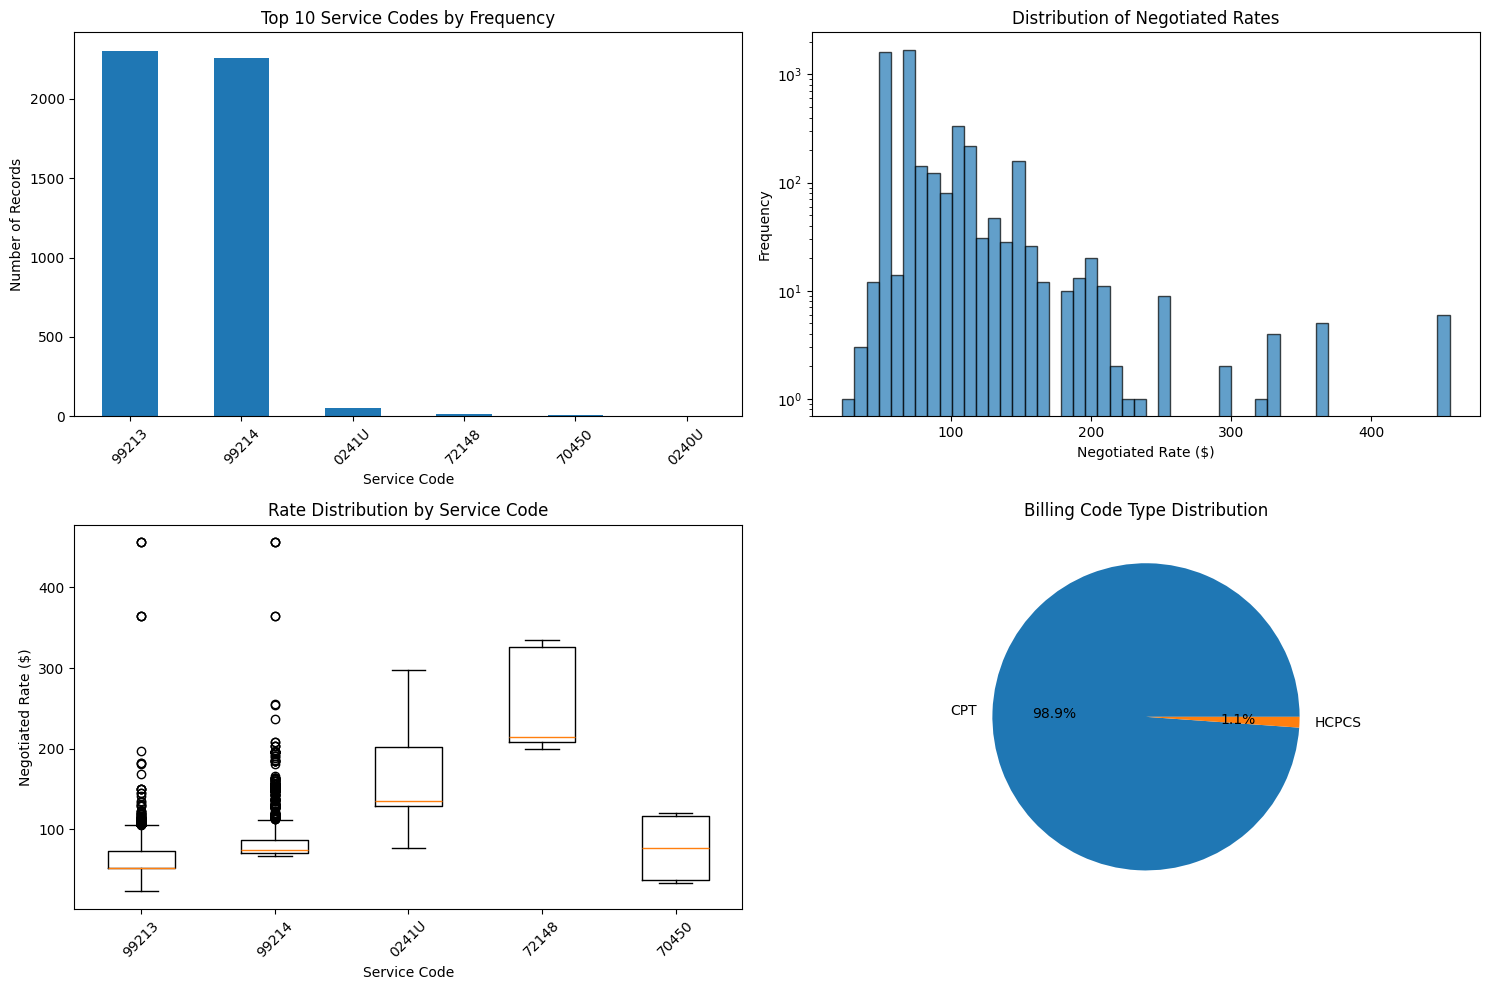

In [14]:
# Cell 4: Service Code Analysis
if rates_df is not None:
    print("🏥 Service Code Analysis")
    print("=" * 50)
    
    # Service code distribution
    service_counts = rates_df['service_code'].value_counts()
    
    print(f"📊 Service Code Summary:")
    print(f"   Unique codes: {len(service_counts):,}")
    print(f"   Total records: {len(rates_df):,}")
    
    print(f"\n🔝 Top 10 Service Codes:")
    for i, (code, count) in enumerate(service_counts.head(10).items(), 1):
        pct = (count / len(rates_df)) * 100
        # Get sample description
        sample_desc = rates_df[rates_df['service_code'] == code]['service_description'].iloc[0]
        desc_short = sample_desc[:50] + "..." if len(sample_desc) > 50 else sample_desc
        print(f"   {i:2d}. {code:8} | {count:6,} records ({pct:5.1f}%) | {desc_short}")
    
    # Rate analysis by service code
    print(f"\n💰 Rate Analysis by Top Service Codes:")
    top_codes = service_counts.head(5).index
    
    rate_stats = []
    for code in top_codes:
        code_data = rates_df[rates_df['service_code'] == code]
        rates = code_data['negotiated_rate']
        
        stats = {
            'Service Code': code,
            'Count': len(code_data),
            'Min Rate': f"${rates.min():.2f}",
            'Max Rate': f"${rates.max():.2f}",
            'Median Rate': f"${rates.median():.2f}",
            'Mean Rate': f"${rates.mean():.2f}",
            'Std Dev': f"${rates.std():.2f}"
        }
        rate_stats.append(stats)
    
    rate_stats_df = pd.DataFrame(rate_stats)
    display(rate_stats_df)
    
    # Plot rate distributions
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Service code frequency
    plt.subplot(2, 2, 1)
    service_counts.head(10).plot(kind='bar')
    plt.title('Top 10 Service Codes by Frequency')
    plt.xlabel('Service Code')
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45)
    
    # Plot 2: Rate distribution
    plt.subplot(2, 2, 2)
    plt.hist(rates_df['negotiated_rate'], bins=50, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Negotiated Rates')
    plt.xlabel('Negotiated Rate ($)')
    plt.ylabel('Frequency')
    plt.yscale('log')
    
    # Plot 3: Box plot of rates by top codes
    plt.subplot(2, 2, 3)
    top_codes_data = []
    labels = []
    for code in top_codes[:5]:
        code_rates = rates_df[rates_df['service_code'] == code]['negotiated_rate']
        top_codes_data.append(code_rates)
        labels.append(code)
    
    plt.boxplot(top_codes_data, labels=labels)
    plt.title('Rate Distribution by Service Code')
    plt.xlabel('Service Code')
    plt.ylabel('Negotiated Rate ($)')
    plt.xticks(rotation=45)
    
    # Plot 4: Billing code type distribution
    plt.subplot(2, 2, 4)
    billing_type_counts = rates_df['billing_code_type'].value_counts()
    plt.pie(billing_type_counts.values, labels=billing_type_counts.index, autopct='%1.1f%%')
    plt.title('Billing Code Type Distribution')
    
    plt.tight_layout()
    plt.show()

--payer analysis

🏢 Payer and Organization Analysis
📊 Market Structure:
   Unique payers: 1
   Unique organizations: 1,812
   Avg records per payer: 4634.0
   Avg records per organization: 2.6

🏥 Provider Network Analysis:
   Records with NPI data: 4,634
   Avg NPIs per rate: 9.9
   Max NPIs in one rate: 767

🗺️  Plan Analysis:
   Unique plan names: 2
   Top 5 plan names:
     1. plan_0 (2,811 records, 60.7%)
     2. plan_1 (1,823 records, 39.3%)

   Plan types:

💲 Rate Variation Analysis:

📊 Rate Variation by Service Code:


,Service Code,Record Count,Mean Rate,Rate Range,Coefficient of Variation,Rate Spread
0,99213,2303,$64.80,$22.85 - $456.00,0.44,668.5%
1,99214,2258,$88.21,$66.66 - $456.00,0.37,441.4%
2,0241U,51,$166.23,$76.31 - $297.52,0.35,133.1%
3,72148,15,$250.09,$199.72 - $334.60,0.24,53.9%
4,70450,6,$76.55,$33.41 - $120.12,0.57,113.3%


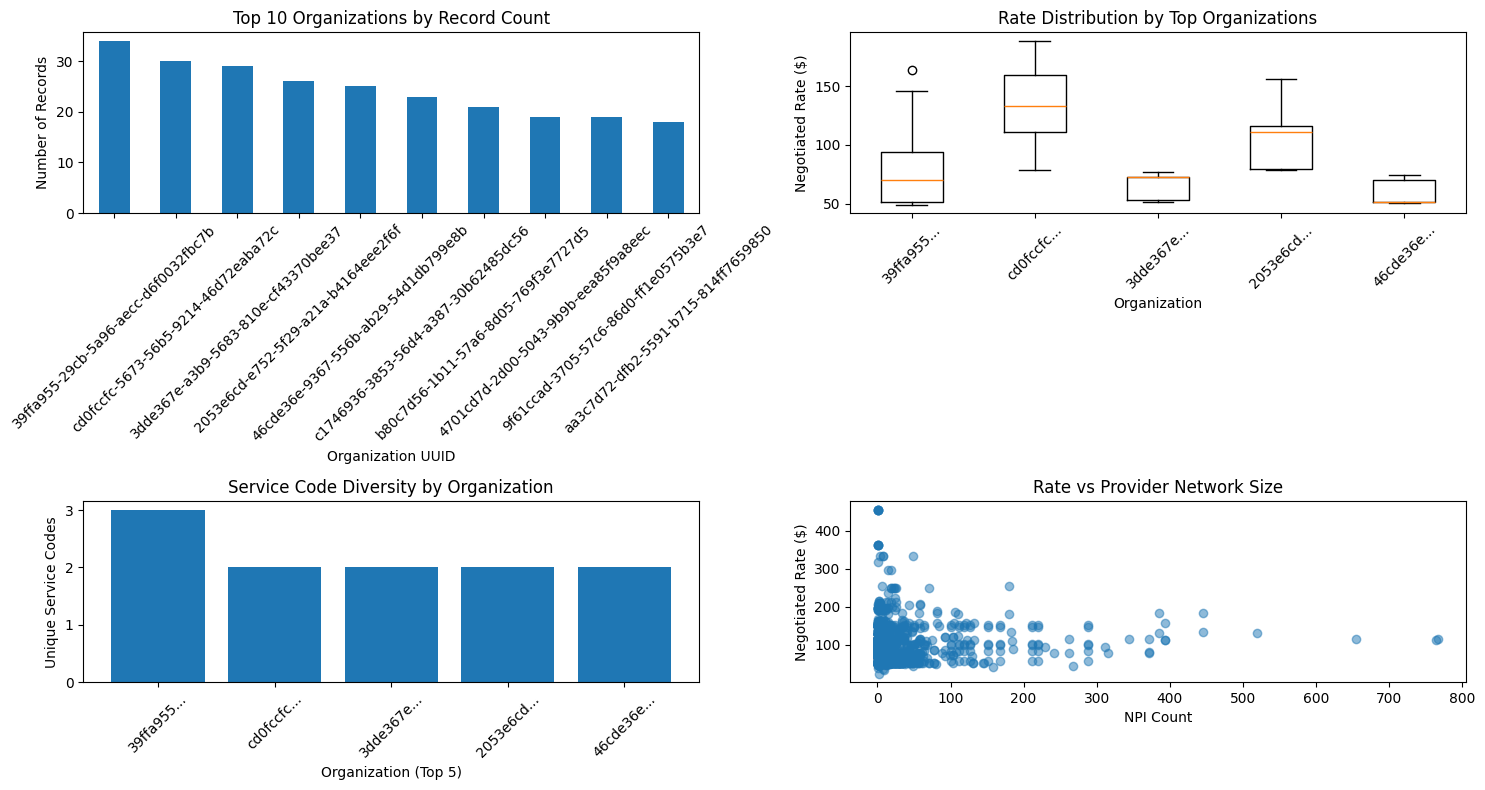

In [15]:
# Cell 5: Payer and Organization Analysis
if rates_df is not None:
    print("🏢 Payer and Organization Analysis")
    print("=" * 50)
    
    # Payer analysis
    payer_counts = rates_df['payer_uuid'].value_counts()
    org_counts = rates_df['organization_uuid'].value_counts()
    
    print(f"📊 Market Structure:")
    print(f"   Unique payers: {len(payer_counts):,}")
    print(f"   Unique organizations: {len(org_counts):,}")
    print(f"   Avg records per payer: {len(rates_df) / len(payer_counts):.1f}")
    print(f"   Avg records per organization: {len(rates_df) / len(org_counts):.1f}")
    
    # Provider network analysis
    if 'provider_network' in rates_df.columns:
        print(f"\n🏥 Provider Network Analysis:")
        
        # Extract NPI counts
        npi_counts = []
        for idx, row in rates_df.iterrows():
            provider_network = row.get('provider_network', {})
            if isinstance(provider_network, dict):
                npi_count = provider_network.get('npi_count', 0)
                npi_counts.append(npi_count)
            else:
                npi_counts.append(0)
        
        npi_counts = pd.Series(npi_counts)
        
        print(f"   Records with NPI data: {(npi_counts > 0).sum():,}")
        print(f"   Avg NPIs per rate: {npi_counts.mean():.1f}")
        print(f"   Max NPIs in one rate: {npi_counts.max():,}")
    
    # Geographic analysis if available
    if 'plan_details' in rates_df.columns:
        print(f"\n🗺️  Plan Analysis:")
        
        plan_names = []
        plan_types = []
        
        for idx, row in rates_df.iterrows():
            plan_details = row.get('plan_details', {})
            if isinstance(plan_details, dict):
                plan_names.append(plan_details.get('plan_name', 'Unknown'))
                plan_types.append(plan_details.get('plan_type', 'Unknown'))
            else:
                plan_names.append('Unknown')
                plan_types.append('Unknown')
        
        plan_name_counts = pd.Series(plan_names).value_counts()
        plan_type_counts = pd.Series(plan_types).value_counts()
        
        print(f"   Unique plan names: {len(plan_name_counts):,}")
        print(f"   Top 5 plan names:")
        for i, (plan, count) in enumerate(plan_name_counts.head(5).items(), 1):
            pct = (count / len(rates_df)) * 100
            plan_short = plan[:40] + "..." if len(plan) > 40 else plan
            print(f"     {i}. {plan_short} ({count:,} records, {pct:.1f}%)")
        
        print(f"\n   Plan types:")
        for plan_type, count in plan_type_counts.items():
            if plan_type != 'Unknown':
                pct = (count / len(rates_df)) * 100
                print(f"     {plan_type}: {count:,} records ({pct:.1f}%)")
    
    # Rate variation analysis
    print(f"\n💲 Rate Variation Analysis:")
    
    # Calculate coefficient of variation for each service code
    service_variation = []
    for code in service_counts.head(10).index:
        code_rates = rates_df[rates_df['service_code'] == code]['negotiated_rate']
        if len(code_rates) > 1 and code_rates.mean() > 0:
            cv = code_rates.std() / code_rates.mean()
            service_variation.append({
                'Service Code': code,
                'Record Count': len(code_rates),
                'Mean Rate': f"${code_rates.mean():.2f}",
                'Rate Range': f"${code_rates.min():.2f} - ${code_rates.max():.2f}",
                'Coefficient of Variation': f"{cv:.2f}",
                'Rate Spread': f"{((code_rates.max() - code_rates.min()) / code_rates.mean() * 100):.1f}%"
            })
    
    if service_variation:
        variation_df = pd.DataFrame(service_variation)
        print(f"\n📊 Rate Variation by Service Code:")
        display(variation_df)
    
    # Visualization
    plt.figure(figsize=(15, 8))
    
    # Plot 1: Top organizations by record count
    plt.subplot(2, 2, 1)
    org_counts.head(10).plot(kind='bar')
    plt.title('Top 10 Organizations by Record Count')
    plt.xlabel('Organization UUID')
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45)
    
    # Plot 2: Rate distribution by organization (top 5)
    plt.subplot(2, 2, 2)
    top_orgs = org_counts.head(5).index
    org_rate_data = []
    org_labels = []
    
    for org in top_orgs:
        org_rates = rates_df[rates_df['organization_uuid'] == org]['negotiated_rate']
        org_rate_data.append(org_rates)
        org_labels.append(org[:8] + "...")  # Truncate for display
    
    plt.boxplot(org_rate_data, labels=org_labels)
    plt.title('Rate Distribution by Top Organizations')
    plt.xlabel('Organization')
    plt.ylabel('Negotiated Rate ($)')
    plt.xticks(rotation=45)
    
    # Plot 3: Service code diversity by organization
    plt.subplot(2, 2, 3)
    org_diversity = []
    for org in top_orgs:
        org_codes = rates_df[rates_df['organization_uuid'] == org]['service_code'].nunique()
        org_diversity.append(org_codes)
    
    plt.bar(range(len(org_diversity)), org_diversity)
    plt.title('Service Code Diversity by Organization')
    plt.xlabel('Organization (Top 5)')
    plt.ylabel('Unique Service Codes')
    plt.xticks(range(len(org_labels)), org_labels, rotation=45)
    
    # Plot 4: Rate vs NPI count scatter (if available)
    plt.subplot(2, 2, 4)
    if len(npi_counts) > 0 and npi_counts.max() > 0:
        plt.scatter(npi_counts, rates_df['negotiated_rate'], alpha=0.5)
        plt.xlabel('NPI Count')
        plt.ylabel('Negotiated Rate ($)')
        plt.title('Rate vs Provider Network Size')
    else:
        plt.text(0.5, 0.5, 'NPI data not available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Rate vs Provider Network Size (No Data)')
    
    plt.tight_layout()
    plt.show()

--query builder

📋 Example Queries:
🔍 Querying S3 data with filters:
   Service codes: ['99213', '99214', '99215']
   Min rate: $50
   Max rate: $500

📊 Results: 4,485 records

💰 Rate Summary:
   Min: $50.40
   Max: $456.00
   Mean: $76.87
   Median: $70.35

🏥 Service Code Breakdown:
   99214: 2,258 records (50.3%)
   99213: 2,227 records (49.7%)

📊 Office Visits Sample:


,service_code,service_description,negotiated_rate,billing_code_type
36,99213,OFFICE OR OTH OUTPATIENT VISIT FOR THE EVALUAT...,72.12,CPT
37,99213,OFFICE OR OTH OUTPATIENT VISIT FOR THE EVALUAT...,52.62,CPT
38,99213,OFFICE OR OTH OUTPATIENT VISIT FOR THE EVALUAT...,52.62,CPT
39,99213,OFFICE OR OTH OUTPATIENT VISIT FOR THE EVALUAT...,52.62,CPT
40,99213,OFFICE OR OTH OUTPATIENT VISIT FOR THE EVALUAT...,52.62,CPT
41,99213,OFFICE OR OTH OUTPATIENT VISIT FOR THE EVALUAT...,52.62,CPT
42,99213,OFFICE OR OTH OUTPATIENT VISIT FOR THE EVALUAT...,52.62,CPT
43,99213,OFFICE OR OTH OUTPATIENT VISIT FOR THE EVALUAT...,52.62,CPT
44,99213,OFFICE OR OTH OUTPATIENT VISIT FOR THE EVALUAT...,52.62,CPT
45,99213,OFFICE OR OTH OUTPATIENT VISIT FOR THE EVALUAT...,52.62,CPT



🔍 Querying S3 data with filters:
   Min rate: $1000

📊 Results: 0 records

🔍 Querying S3 data with filters:
   Service codes: ['70450', '72148', '73721', '74177']

📊 Results: 21 records

💰 Rate Summary:
   Min: $33.41
   Max: $334.60
   Mean: $200.50
   Median: $208.54

🏥 Service Code Breakdown:
   72148: 15 records (71.4%)
   70450: 6 records (28.6%)

🔬 Imaging Procedures Sample:


,service_code,service_description,negotiated_rate
29,70450,"COMPUTED TOMOGRAPHY, HEAD OR BRAIN; WITHOUT CO...",41.76
30,72148,"MAGNETIC RESONANCE (EG, PROTON) IMAGING, SPINA...",214.37
31,72148,"MAGNETIC RESONANCE (EG, PROTON) IMAGING, SPINA...",210.43
32,72148,"MAGNETIC RESONANCE (EG, PROTON) IMAGING, SPINA...",208.54
33,72148,"MAGNETIC RESONANCE (EG, PROTON) IMAGING, SPINA...",199.72
34,72148,"MAGNETIC RESONANCE (EG, PROTON) IMAGING, SPINA...",199.72
35,72148,"MAGNETIC RESONANCE (EG, PROTON) IMAGING, SPINA...",334.60
2834,70450,"COMPUTED TOMOGRAPHY, HEAD OR BRAIN; WITHOUT CO...",117.41
2835,70450,"COMPUTED TOMOGRAPHY, HEAD OR BRAIN; WITHOUT CO...",35.17
2836,70450,"COMPUTED TOMOGRAPHY, HEAD OR BRAIN; WITHOUT CO...",111.43


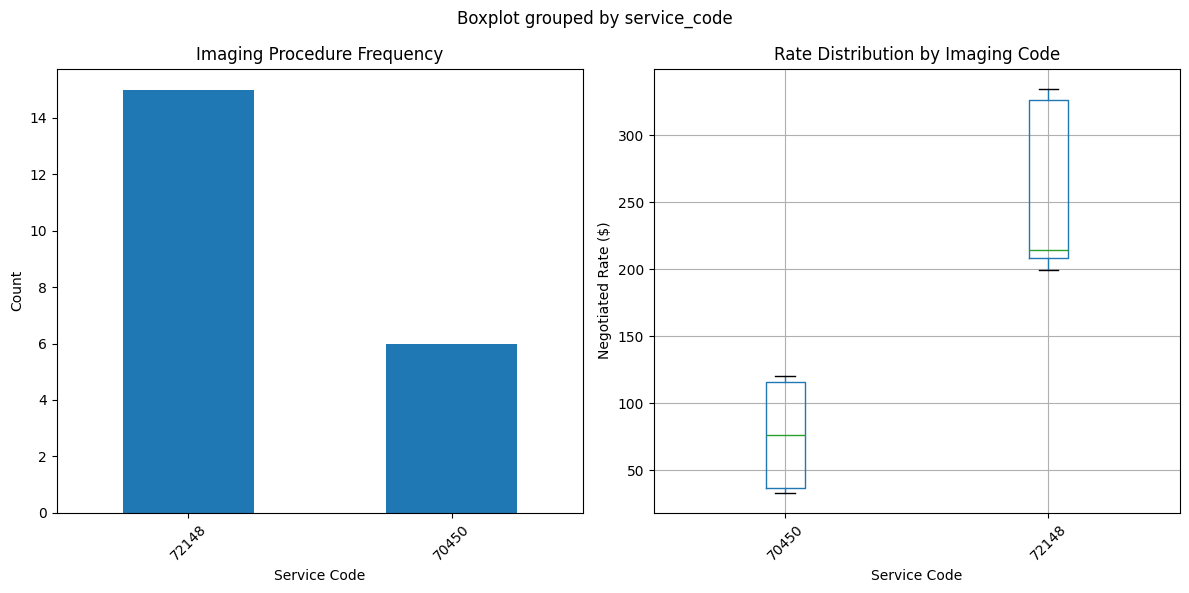


🔧 Custom Query Builder
Use this function to build your own queries:

Examples:
  # Query specific codes
  my_data = query_s3_data(service_codes=['99213', '99214'])

  # Query by rate range
  expensive = query_s3_data(min_rate=500, max_rate=2000)

  # Combined filters
  filtered = query_s3_data(
      service_codes=['70450'], 
      min_rate=100, 
      max_rate=1000,
      max_records=1000
  )


In [16]:
# Cell 6: Interactive Query Builder for S3 Data
def query_s3_data(service_codes=None, min_rate=None, max_rate=None, 
                  payer_filter=None, max_records=10000):
    """
    Query S3 data with filters.
    
    Args:
        service_codes: List of service codes to filter on
        min_rate: Minimum negotiated rate
        max_rate: Maximum negotiated rate
        payer_filter: Payer UUID to filter on
        max_records: Maximum records to return
    """
    
    if rates_df is None:
        print("❌ No rates data loaded. Run previous cells first.")
        return None
    
    print(f"🔍 Querying S3 data with filters:")
    
    # Start with full dataset
    filtered_df = rates_df.copy()
    
    # Apply filters
    if service_codes:
        if isinstance(service_codes, str):
            service_codes = [service_codes]
        filtered_df = filtered_df[filtered_df['service_code'].isin(service_codes)]
        print(f"   Service codes: {service_codes}")
    
    if min_rate is not None:
        filtered_df = filtered_df[filtered_df['negotiated_rate'] >= min_rate]
        print(f"   Min rate: ${min_rate}")
    
    if max_rate is not None:
        filtered_df = filtered_df[filtered_df['negotiated_rate'] <= max_rate]
        print(f"   Max rate: ${max_rate}")
    
    if payer_filter:
        filtered_df = filtered_df[filtered_df['payer_uuid'] == payer_filter]
        print(f"   Payer: {payer_filter}")
    
    # Limit results
    if len(filtered_df) > max_records:
        filtered_df = filtered_df.sample(n=max_records, random_state=42)
        print(f"   Sampled {max_records} records from {len(filtered_df)} matches")
    
    print(f"\n📊 Results: {len(filtered_df):,} records")
    
    if len(filtered_df) > 0:
        # Summary statistics
        print(f"\n💰 Rate Summary:")
        rates = filtered_df['negotiated_rate']
        print(f"   Min: ${rates.min():.2f}")
        print(f"   Max: ${rates.max():.2f}")
        print(f"   Mean: ${rates.mean():.2f}")
        print(f"   Median: ${rates.median():.2f}")
        
        # Service code breakdown
        if len(filtered_df['service_code'].unique()) > 1:
            print(f"\n🏥 Service Code Breakdown:")
            code_counts = filtered_df['service_code'].value_counts()
            for code, count in code_counts.items():
                pct = (count / len(filtered_df)) * 100
                print(f"   {code}: {count:,} records ({pct:.1f}%)")
    
    return filtered_df

# Example queries - modify these as needed

print("📋 Example Queries:")
print("=" * 50)

# Query 1: Office visits
office_visits = query_s3_data(
    service_codes=['99213', '99214', '99215'],
    min_rate=50,
    max_rate=500
)

if office_visits is not None and len(office_visits) > 0:
    print(f"\n📊 Office Visits Sample:")
    display(office_visits[['service_code', 'service_description', 'negotiated_rate', 
                          'billing_code_type']].head(10))

print("\n" + "="*50)

# Query 2: High-value procedures
high_value = query_s3_data(
    min_rate=1000,
    max_records=100
)

if high_value is not None and len(high_value) > 0:
    print(f"\n💎 High-Value Procedures Sample:")
    display(high_value[['service_code', 'service_description', 'negotiated_rate', 
                       'billing_code_type']].head(10))

print("\n" + "="*50)

# Query 3: Imaging procedures
imaging_codes = ['70450', '72148', '73721', '74177']
imaging = query_s3_data(
    service_codes=imaging_codes,
    max_records=500
)

if imaging is not None and len(imaging) > 0:
    print(f"\n🔬 Imaging Procedures Sample:")
    display(imaging[['service_code', 'service_description', 'negotiated_rate']].head(10))
    
    # Plot imaging rates
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    imaging['service_code'].value_counts().plot(kind='bar')
    plt.title('Imaging Procedure Frequency')
    plt.xlabel('Service Code')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    imaging.boxplot(column='negotiated_rate', by='service_code', ax=plt.gca())
    plt.title('Rate Distribution by Imaging Code')
    plt.xlabel('Service Code')
    plt.ylabel('Negotiated Rate ($)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Custom query function for interactive use
def custom_query():
    """Interactive query builder."""
    print("\n🔧 Custom Query Builder")
    print("Use this function to build your own queries:")
    print()
    print("Examples:")
    print("  # Query specific codes")
    print("  my_data = query_s3_data(service_codes=['99213', '99214'])")
    print()
    print("  # Query by rate range")
    print("  expensive = query_s3_data(min_rate=500, max_rate=2000)")
    print()
    print("  # Combined filters")
    print("  filtered = query_s3_data(")
    print("      service_codes=['70450'], ")
    print("      min_rate=100, ")
    print("      max_rate=1000,")
    print("      max_records=1000")
    print("  )")

custom_query()

-- provider analysis

In [1]:
# Provider Data Analysis - TIN and NPI Investigation
def analyze_provider_data():
    """Load and analyze provider parquet files to understand TIN/NPI structure."""
    
    if not file_structure.get('providers'):
        print("❌ No provider files found")
        return None
    
    print("🏥 Loading Provider Data")
    print("=" * 50)
    
    # Load provider files
    provider_dfs = []
    for file_info in file_structure['providers'][:3]:  # Load first 3 files
        try:
            file_path = file_info['path']
            file_name = file_path.split('/')[-1]
            print(f"   Loading: {file_name}")
            
            df = pd.read_parquet(file_path)
            provider_dfs.append(df)
            
        except Exception as e:
            print(f"     ❌ Error loading {file_name}: {e}")
    
    if not provider_dfs:
        print("❌ No provider files could be loaded")
        return None
    
    # Combine provider data
    providers_df = pd.concat(provider_dfs, ignore_index=True)
    
    print(f"\n📊 Provider Data Overview:")
    print(f"   Shape: {providers_df.shape}")
    print(f"   Memory usage: {providers_df.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")
    
    print(f"\n📋 Provider Columns:")
    for i, col in enumerate(providers_df.columns, 1):
        dtype = str(providers_df[col].dtype)
        null_count = providers_df[col].isnull().sum()
        null_pct = (null_count / len(providers_df)) * 100
        print(f"   {i:2d}. {col:25} | {dtype:15} | {null_count:6,} nulls ({null_pct:4.1f}%)")
    
    print(f"\n📈 Provider Sample Data:")
    display(providers_df.head())
    
    return providers_df

def analyze_organization_data():
    """Load and analyze organization parquet files to understand TIN structure."""
    
    if not file_structure.get('organizations'):
        print("❌ No organization files found")
        return None
    
    print("\n🏢 Loading Organization Data")
    print("=" * 50)
    
    # Load organization files
    org_dfs = []
    for file_info in file_structure['organizations'][:3]:  # Load first 3 files
        try:
            file_path = file_info['path']
            file_name = file_path.split('/')[-1]
            print(f"   Loading: {file_name}")
            
            df = pd.read_parquet(file_path)
            org_dfs.append(df)
            
        except Exception as e:
            print(f"     ❌ Error loading {file_name}: {e}")
    
    if not org_dfs:
        print("❌ No organization files could be loaded")
        return None
    
    # Combine organization data
    orgs_df = pd.concat(org_dfs, ignore_index=True)
    
    print(f"\n📊 Organization Data Overview:")
    print(f"   Shape: {orgs_df.shape}")
    
    print(f"\n📋 Organization Columns:")
    for i, col in enumerate(orgs_df.columns, 1):
        dtype = str(orgs_df[col].dtype)
        null_count = orgs_df[col].isnull().sum()
        null_pct = (null_count / len(orgs_df)) * 100
        print(f"   {i:2d}. {col:25} | {dtype:15} | {null_count:6,} nulls ({null_pct:4.1f}%)")
    
    print(f"\n📈 Organization Sample Data:")
    display(orgs_df.head())
    
    return orgs_df

def analyze_tin_npi_relationships(rates_df, providers_df=None, orgs_df=None):
    """Analyze TIN/NPI relationships in the rates data."""
    
    print("\n🔍 TIN/NPI Relationship Analysis")
    print("=" * 50)
    
    # Analyze provider_network field in rates data
    print("📊 Provider Network Analysis in Rates Data:")
    
    provider_networks = rates_df['provider_network'].apply(
        lambda x: x if isinstance(x, dict) else {}
    )
    
    # Extract NPI information
    npi_counts = []
    npi_lists = []
    
    for network in provider_networks:
        npi_list = network.get('npi_list', [])
        npi_count = network.get('npi_count', 0)
        
        npi_counts.append(npi_count)
        if isinstance(npi_list, list) and npi_list:
            npi_lists.extend(npi_list)
    
    npi_counts = pd.Series(npi_counts)
    unique_npis = set(npi_lists) if npi_lists else set()
    
    print(f"   Records with NPI data: {(npi_counts > 0).sum():,}")
    print(f"   Total NPI associations: {npi_counts.sum():,}")
    print(f"   Unique NPIs: {len(unique_npis):,}")
    print(f"   Avg NPIs per rate: {npi_counts.mean():.1f}")
    print(f"   Max NPIs in one rate: {npi_counts.max():,}")
    
    # NPI distribution
    print(f"\n📈 NPI Count Distribution:")
    npi_dist = npi_counts.value_counts().sort_index()
    for count, freq in npi_dist.head(10).items():
        print(f"   {count:3d} NPIs: {freq:,} rates")
    
    # Analyze organization relationships
    org_counts = rates_df['organization_uuid'].value_counts()
    print(f"\n🏢 Organization Analysis:")
    print(f"   Unique organizations: {len(org_counts):,}")
    print(f"   Avg rates per organization: {len(rates_df) / len(org_counts):.1f}")
    
    print(f"\n🔝 Top 10 Organizations by Rate Count:")
    for i, (org_uuid, count) in enumerate(org_counts.head(10).items(), 1):
        print(f"   {i:2d}. {org_uuid[:20]}... {count:,} rates")
    
    # Sample some actual NPI values
    if npi_lists:
        sample_npis = list(unique_npis)[:10]
        print(f"\n📋 Sample NPIs:")
        for npi in sample_npis:
            print(f"   {npi}")
    
    return {
        'npi_counts': npi_counts,
        'unique_npis': unique_npis,
        'org_counts': org_counts
    }

# Run the analysis
print("🔍 Comprehensive Provider/TIN/NPI Analysis")
print("=" * 60)

# Load provider data
providers_df = analyze_provider_data()

# Load organization data  
orgs_df = analyze_organization_data()

# Analyze relationships
if rates_df is not None:
    relationship_analysis = analyze_tin_npi_relationships(rates_df, providers_df, orgs_df)
else:
    print("❌ No rates data available for relationship analysis")

🔍 Comprehensive Provider/TIN/NPI Analysis


NameError: name 'file_structure' is not defined